### Question 2

In [99]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Data Creation
dat = make_blobs(n_samples=1000, n_features=16, random_state=42)
x = dat[0]
y = dat[1]

#### K-means from scratch

In [100]:
import copy
def my_k_means(data, K, max_iter = 1000, min_update = 1e-6):
    
    # Randomly choose k data points as the intial centroid
    centroids = data[np.random.choice(len(data), K, replace=False)]
    iter = 0
    update = 999
    while iter < max_iter or update > min_update:
        # Retain location of previous centroid
        prev_centroid = copy.deepcopy(centroids)
        assign_to = []
        for d in data:
            # Calculate distance of each data point to each of the centroids
            dist = np.sqrt(np.sum(np.subtract(d, centroids)**2, axis = 1))
            # Assign data point to closest centroid
            assign_to.append(np.argmin(dist, axis = 0))
     
        for k in range(K):
            # Update centroids using mean of data points assigned to that centroid
            centroids[k] = np.mean(data[np.equal(assign_to, k)], axis = 0)
        # Calculate distance between previous and current centroid locations as stopping criteria
        update = np.min(np.sqrt(np.sum(np.subtract(prev_centroid, centroids)**2, axis = 1)))
        iter += 1

    return assign_to, centroids
            


#### Elbow plot

/home/henry/workspace/fitx-env/lib/python3.10/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/henry/workspace/fitx-env/lib/python3.10/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


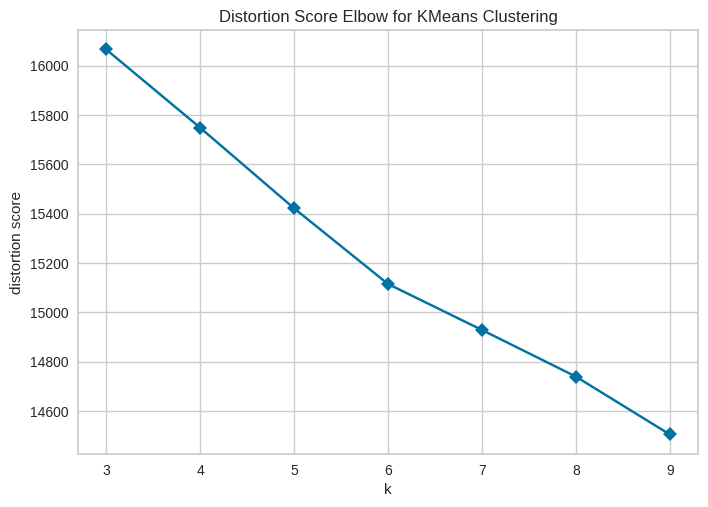

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Inspiration from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

kmeans = KMeans()
viz = KElbowVisualizer(kmeans, k = (3,10), timings = False)
viz.fit(x)
viz.show()

#### Silhouette Plot

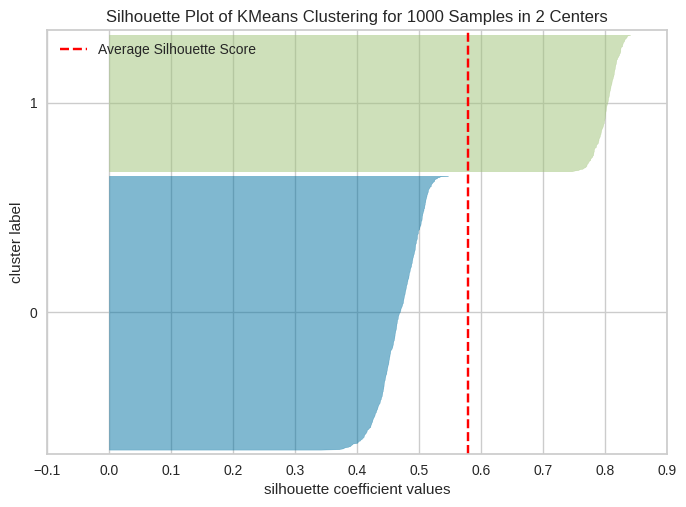

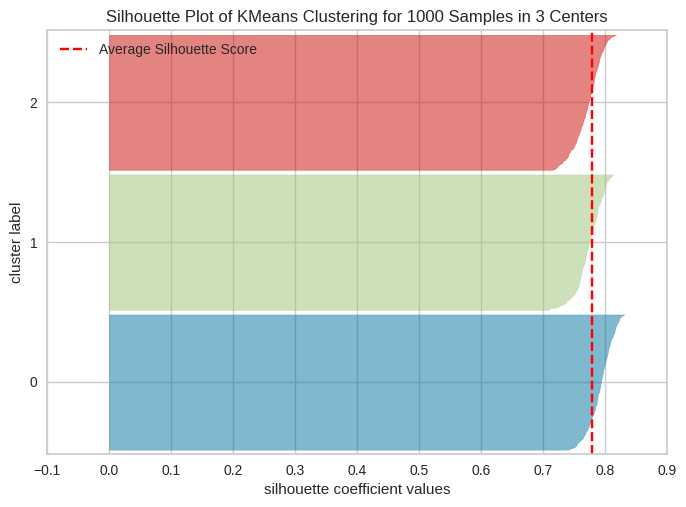

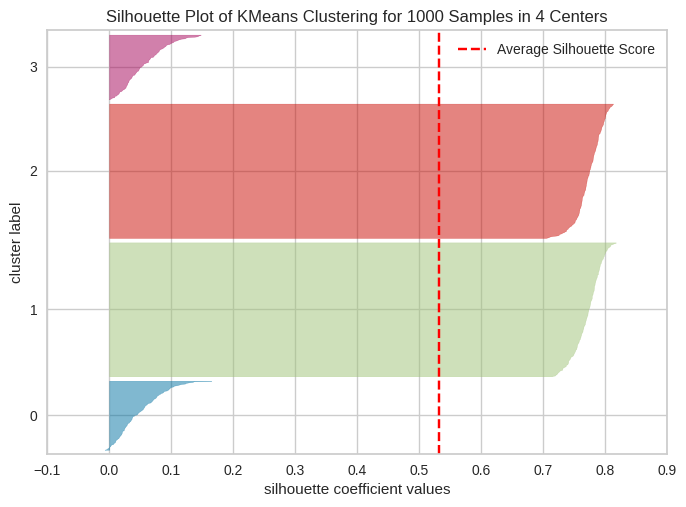

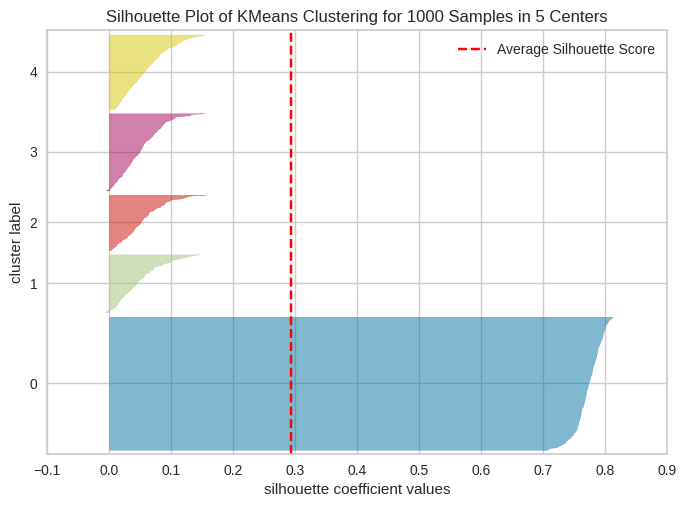

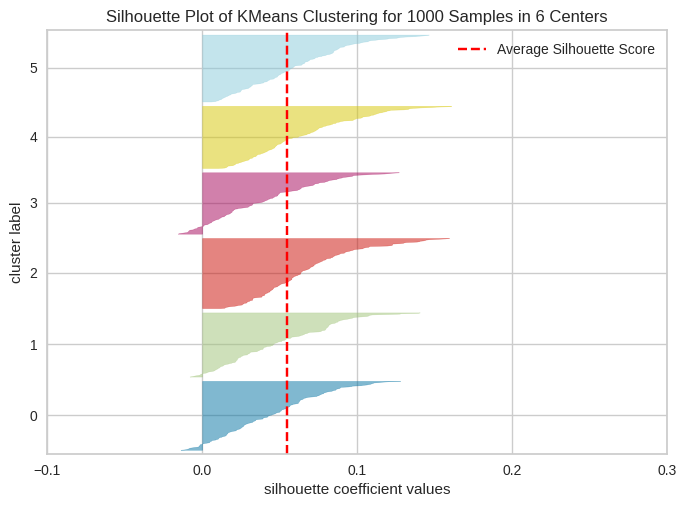

In [102]:
from yellowbrick.cluster import SilhouetteVisualizer
K = [2, 3, 4, 5, 6]
for k in K:
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(x)        # Fit the data to the visualizer
    visualizer.show()
    

#### Re-cluster 

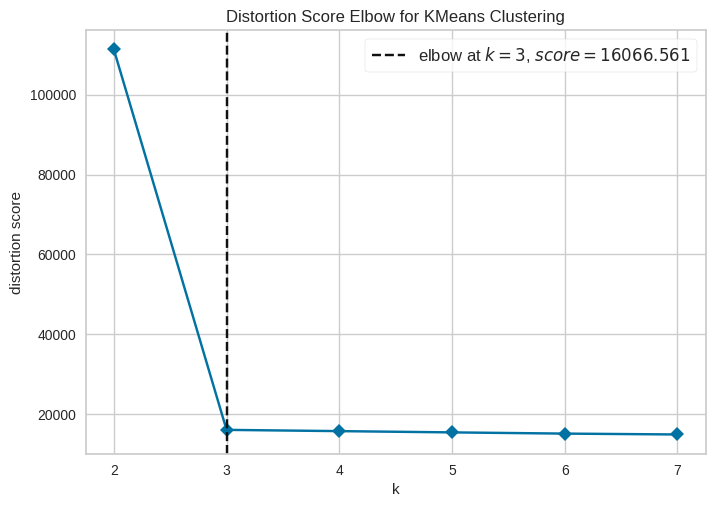

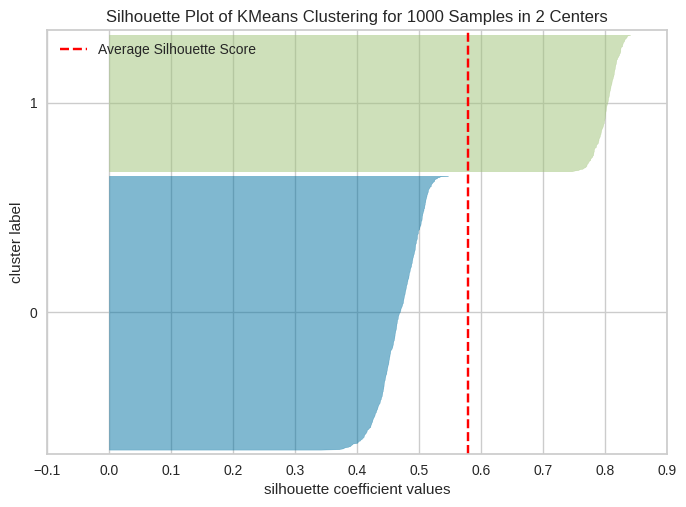

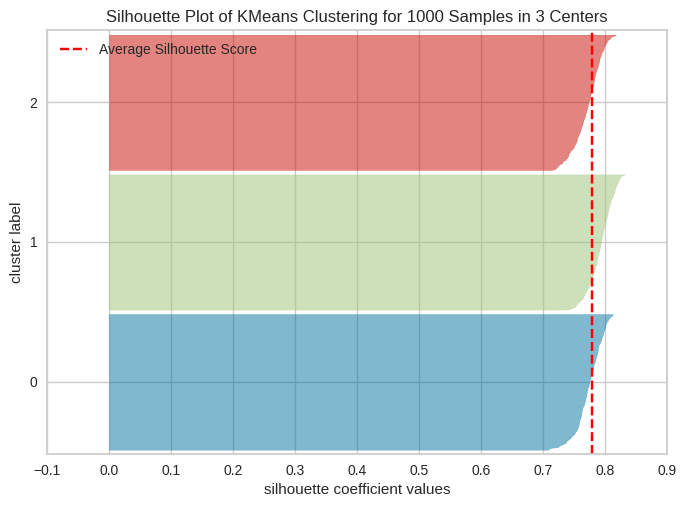

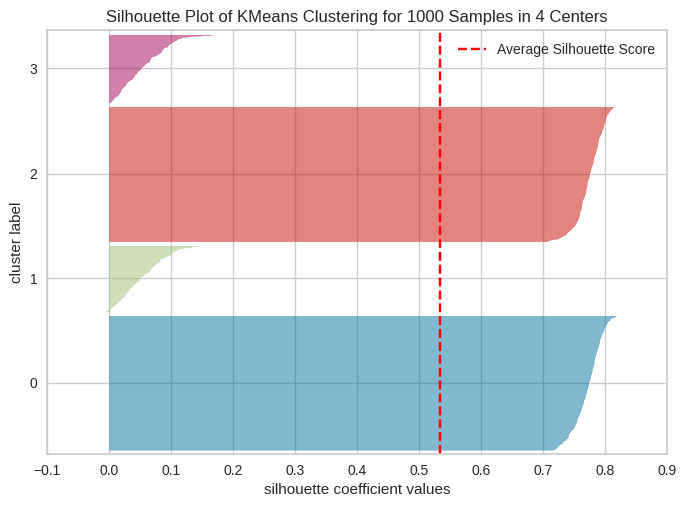

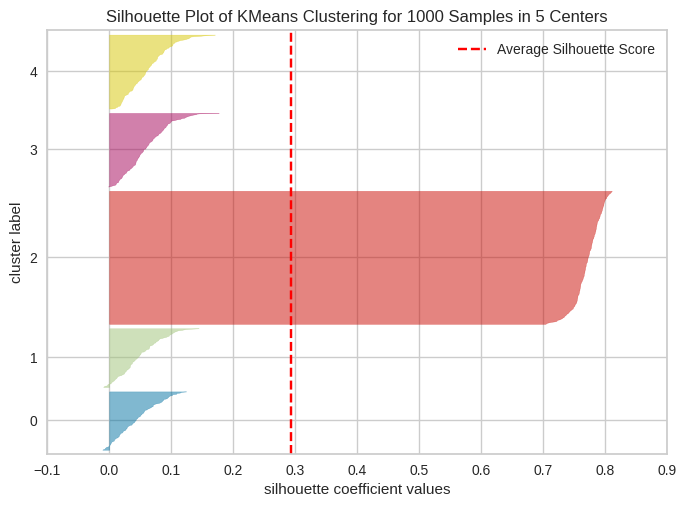

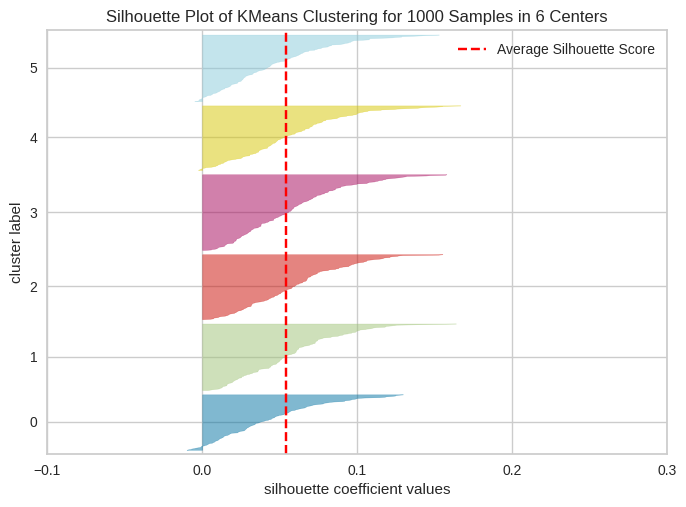

In [103]:
K = [2, 3, 4, 5, 6]
kmeans = KMeans()
viz = KElbowVisualizer(kmeans, k = (2,8), timings = False)
viz.fit(x)
viz.show()
for k in K:
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(x)        # Fit the data to the visualizer
    visualizer.show()

#### PCA

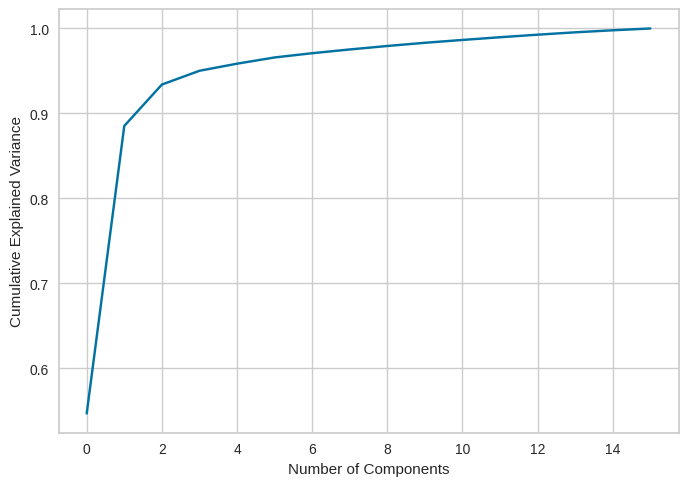

In [104]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator

sc = StandardScaler()
std_dat = sc.fit_transform(x)
pca = PCA()
pca.fit(std_dat)

ax = plt.figure().gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

As seen above, after 3 components, the cumulative explain variance does not increase significantly. Thus, we will only take the first 3 PC's

In [105]:
important = pca.components_[[0,1,2]]
dim_reduced = np.dot(std_dat, important.T)
dim_reduced.shape

(1000, 3)

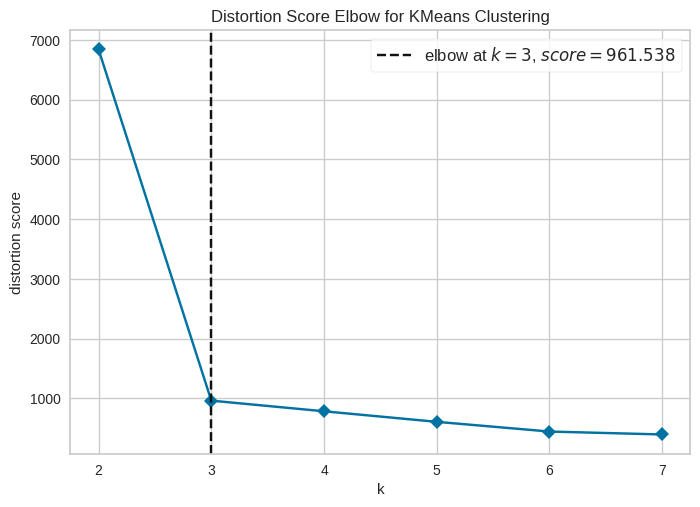

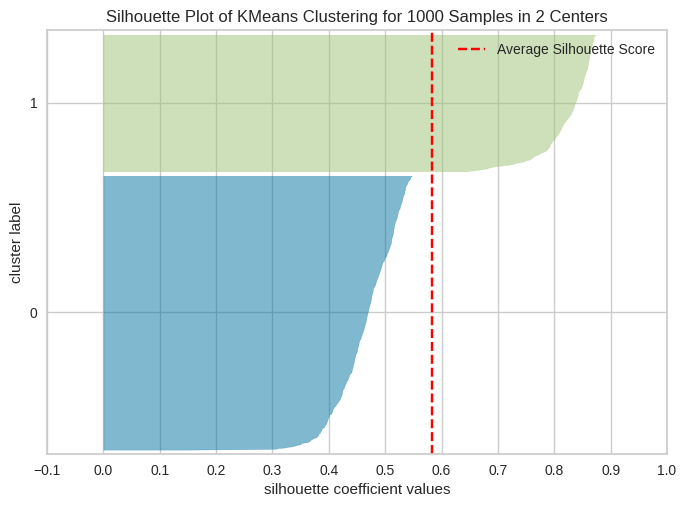

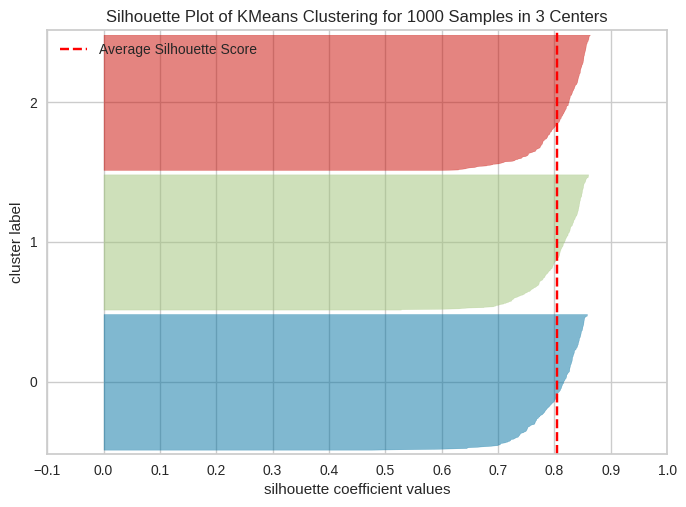

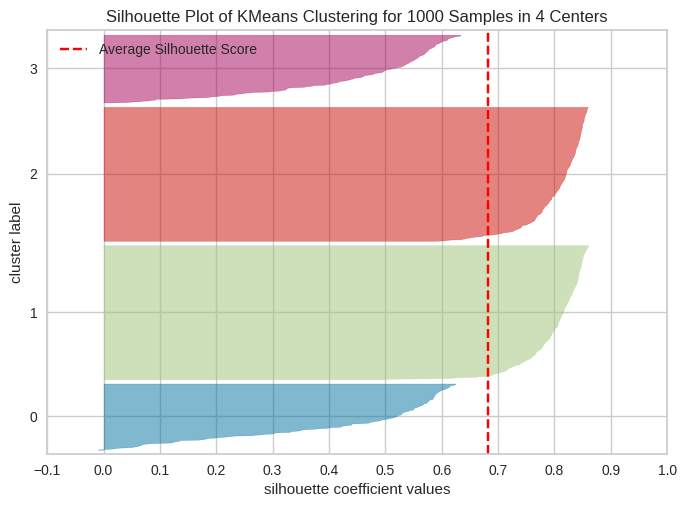

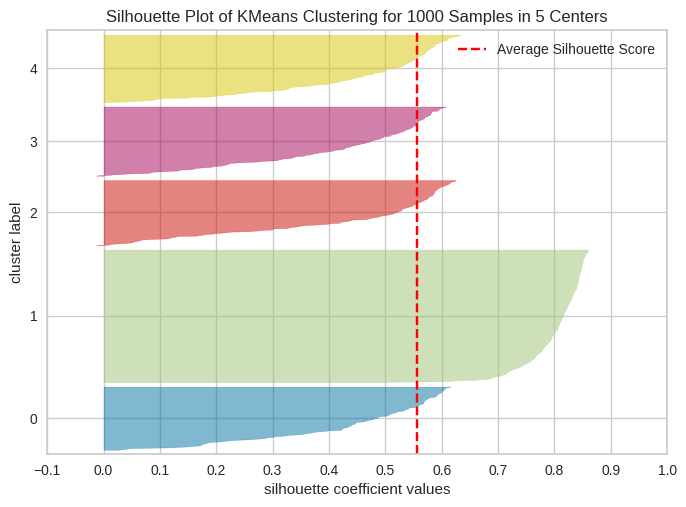

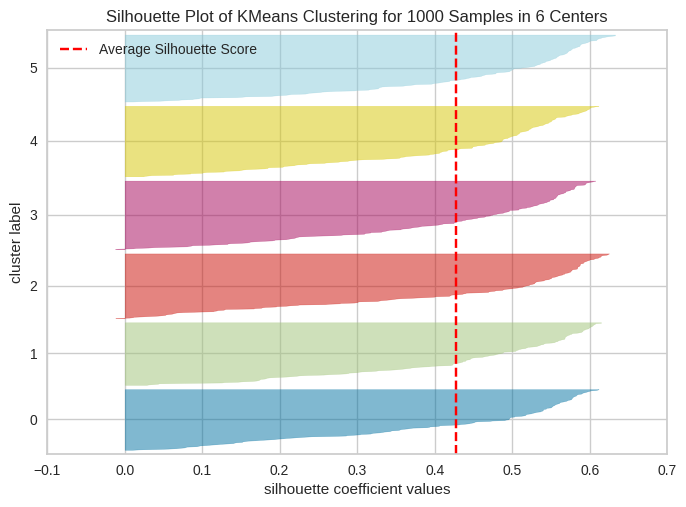

In [106]:
K = [2, 3, 4, 5, 6]
kmeans = KMeans()
viz = KElbowVisualizer(kmeans, k = (2,8), timings = False)
viz.fit(dim_reduced)
viz.show()
for k in K:
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(dim_reduced)        # Fit the data to the visualizer
    visualizer.show()

As seen above, the quality of the clusters shown by the silhouette plots have significantly increased compared to the non-PCA data. 3 clusters seems to be the best. The time it took to run was also much faster.

### Question 3

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", low_memory=False)

#### Data Transformation

In [110]:
df = df[(df.YearStart == 2020)]
df = df.dropna(axis=1,how='all')
df = df[(df.DataValueUnit == '%')]
df = df.drop(['LocationDesc', 'DataSource',
              'DatavalueFootnote','DataValueFootnoteSymbol',
              'LowConfidenceLimit','HighConfidenceLimit',
              'DataValueAlt','LocationID','YearStart','YearEnd',
              'GeoLocation','StratificationCategoryID1','DataValueUnit','DataValueTypeID'], axis=1)
df.dropna(subset=['DataValue'],inplace=True)


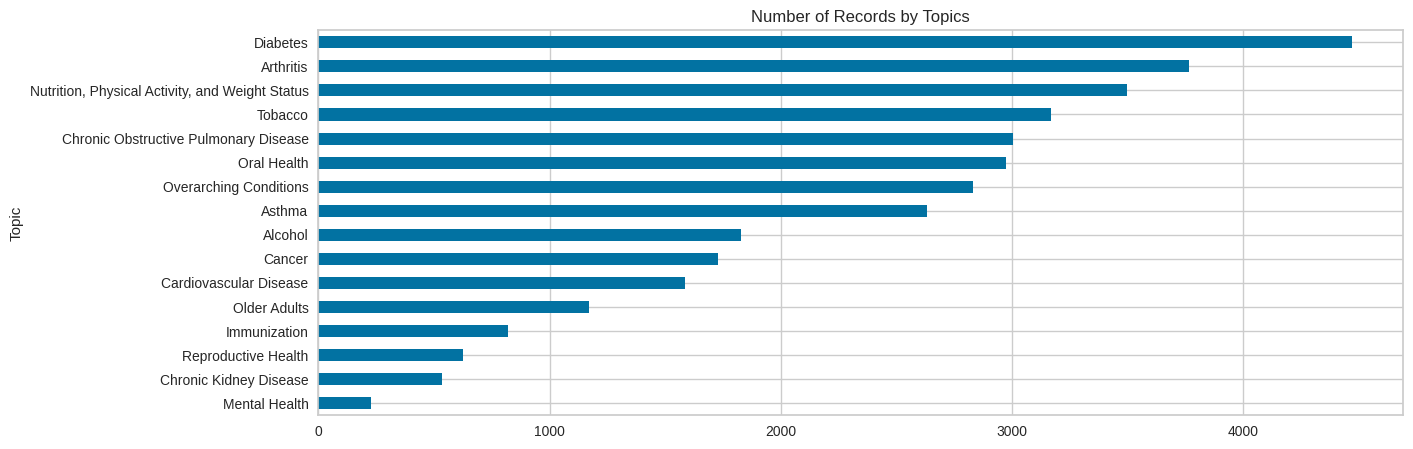

In [111]:
df.groupby('Topic').size().sort_values(ascending=True)\
    .plot(title="Number of Records by Topics", kind='barh',figsize=(14,5))
plt.show()

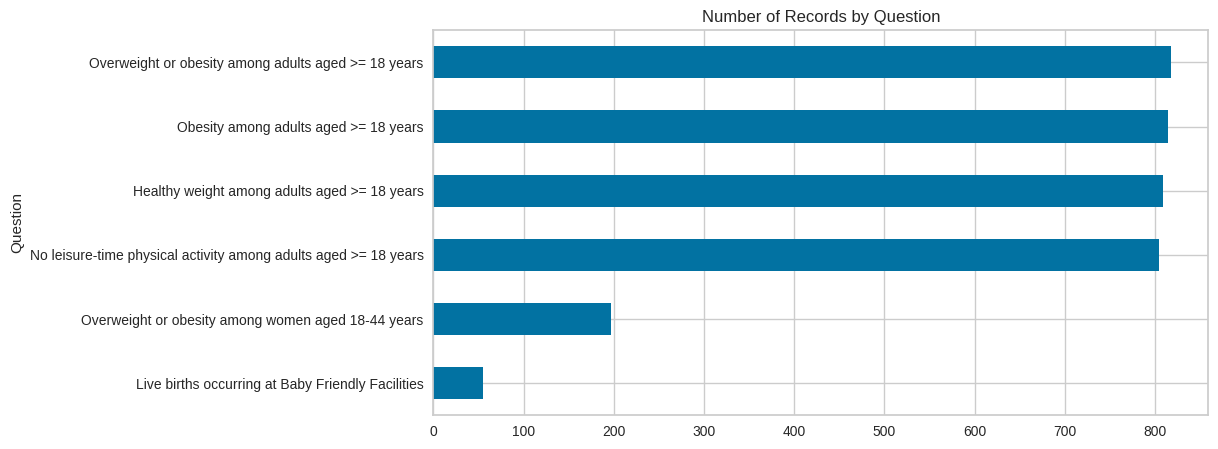

In [120]:
# Look at questions for Nutrition, Physical Activiy, and Weight status
df[df.Topic == 'Nutrition, Physical Activity, and Weight Status'].groupby('Question').size().sort_values(ascending=True).plot(title="Number of Records by Question",kind='barh',figsize=(10,5))
plt.show()

In [181]:
# Filter down dataset to 2020, 1 topic (Nutrition, Physcial Activity, and Weight Status), and 3 questions 
qs = ['Obesity among adults aged >= 18 years', 'No leisure-time physical activity among adults aged >= 18 years', 'Healthy weight among adults aged >= 18 years']
final_df = df[df.Topic == 'Nutrition, Physical Activity, and Weight Status']
final_df = final_df[final_df['Question'].isin(qs)]
final_df = final_df[(final_df.DataValueType == 'Crude Prevalence')]
final_df = final_df[(final_df.StratificationCategory1 == 'Gender')]
final_df.loc[:, 'DataValue'] = pd.to_numeric(final_df.loc[:, 'DataValue'])

/tmp/ipykernel_527588/263417454.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_df.loc[:, 'DataValue'] = pd.to_numeric(final_df.loc[:, 'DataValue'])


In [182]:
final_df

,LocationAbbr,Topic,Question,DataValueType,DataValue,StratificationCategory1,Stratification1,TopicID,QuestionID,StratificationID1
531462,AK,"Nutrition, Physical Activity, and Weight Status",No leisure-time physical activity among adults...,Crude Prevalence,24.7,Gender,Female,NPAW,NPAW10_0,GENF
532120,AK,"Nutrition, Physical Activity, and Weight Status",Healthy weight among adults aged >= 18 years,Crude Prevalence,26.0,Gender,Male,NPAW,NPAW3_1,GENM
535717,AK,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,Crude Prevalence,33.8,Gender,Male,NPAW,NPAW1_1,GENM
536677,AK,"Nutrition, Physical Activity, and Weight Status",Healthy weight among adults aged >= 18 years,Crude Prevalence,38.6,Gender,Female,NPAW,NPAW3_1,GENF
538681,AK,"Nutrition, Physical Activity, and Weight Status",No leisure-time physical activity among adults...,Crude Prevalence,18.2,Gender,Male,NPAW,NPAW10_0,GENM
...,...,...,...,...,...,...,...,...,...,...
1183127,WY,"Nutrition, Physical Activity, and Weight Status",Healthy weight among adults aged >= 18 years,Crude Prevalence,38.7,Gender,Female,NPAW,NPAW3_1,GENF
1183609,WY,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,Crude Prevalence,30.1,Gender,Male,NPAW,NPAW1_1,GENM
1184435,WY,"Nutrition, Physical Activity, and Weight Status",Healthy weight among adults aged >= 18 years,Crude Prevalence,25.1,Gender,Male,NPAW,NPAW3_1,GENM
1184540,WY,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,Crude Prevalence,31.4,Gender,Female,NPAW,NPAW1_1,GENF


In [183]:
df11 = final_df.pivot(index=['LocationAbbr', 'Stratification1'],columns=['Question'], values=['DataValue'])
df11.columns = df11.columns.get_level_values(1)
gender_df = df11.reset_index()
gender_df.columns = ['Loc', 'Gender','Healthy Weight', 'No Physical Activity', 'Obesity']
gender_df

,Loc,Gender,Healthy Weight,No Physical Activity,Obesity
0,AK,Female,38.6,24.7,29.6
1,AK,Male,26.0,18.2,33.8
2,AL,Female,28.0,32.1,40.3
3,AL,Male,22.8,25.2,37.7
4,AR,Female,34.1,34.0,39.1
...,...,...,...,...,...
103,WI,Male,24.6,19.0,32.5
104,WV,Female,30.8,33.2,37.6
105,WV,Male,22.9,26.0,40.5
106,WY,Female,38.7,24.6,31.4


#### EDA

In [184]:
gender_df.describe()

,Healthy Weight,No Physical Activity,Obesity
count,108.000000,108.000000,108.000000
mean,31.425926,23.471296,32.063889
std,5.951162,5.299304,4.270951
min,21.600000,13.900000,19.100000
25%,26.200000,20.375000,28.850000
50%,30.550000,22.550000,32.000000
75%,35.450000,25.375000,35.125000
max,46.300000,51.100000,42.800000


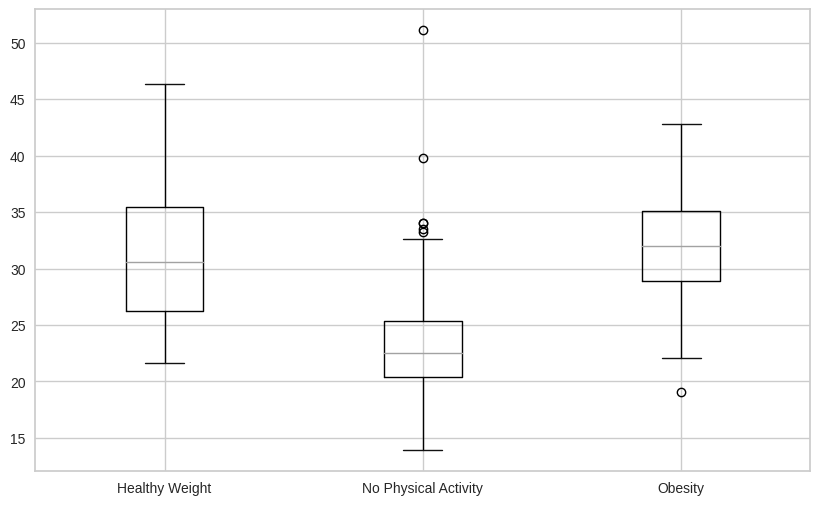

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))
gender_df.boxplot(ax=ax)
plt.show()

/tmp/ipykernel_527588/1476075503.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gender_corr = gender_df.corr()


<AxesSubplot:>

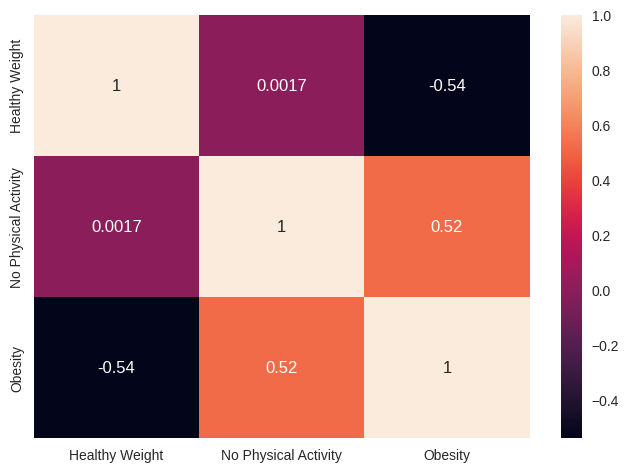

In [186]:
import seaborn as sns
gender_corr = gender_df.corr()
sns.heatmap(gender_corr, annot=True)

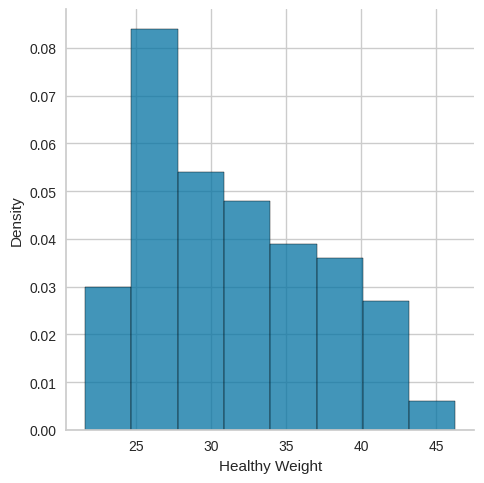

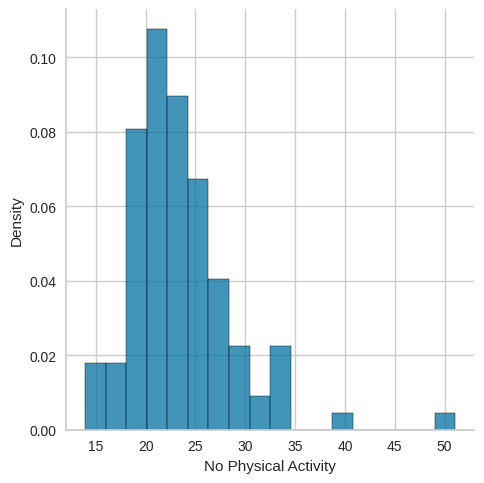

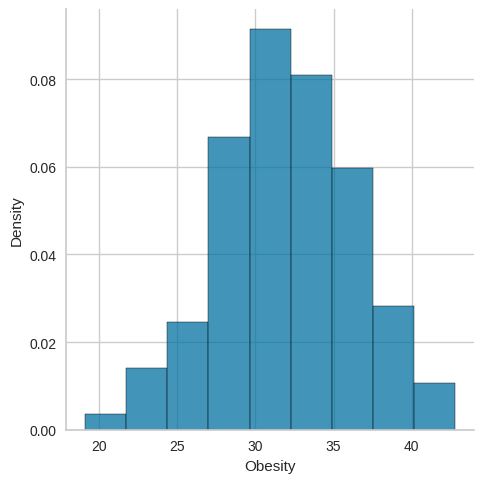

In [187]:
sns.displot(gender_df['Healthy Weight'], stat = 'density')
sns.displot(gender_df['No Physical Activity'], stat = 'density')
sns.displot(gender_df['Obesity'], stat = 'density')


#### Clustering

Using these 3 questions:
1. Obesity among adults aged >= 18 years
2. No leisure-time physical activity among adults aged >= 18 years
3. Healthy weight among adults aged >= 18 years

We can conduct cluster analysis to determine how each (Location, Gender) combination is similar to each other in terms of these 3 questions. By doing so, we can identify the groups that need more attention to address these problems.

It is useful to try the following algorithms

1. KMeans: 
    - Pros: It is the simplest clustering algorithm and can be used as a baseline for other methods
    - Cons: Very sensitive to outliers, must have spherical clusters
2. KMedians: 
    - Pros: This is an evolution of KMeans. Looking at the plots above, there seem to be a few outliers in the No Physical Activity group. KMedians is robust to outliers while 
    - Cons: Needs spherical clusters
3. DBSCAN: 
    - Pros: Fixes many issues of KMeans. Does not need spherical clusters and can find clusters within clusters. It is also robust to outliers
    - Cons: Sensitive to clusters with varying density (epsilon and min_samples to determine corepoints are fixed)

#### KMeans

In [193]:
# Standardize data
sc = StandardScaler()
gender_st = copy.deepcopy(gender_df)
gender_st.iloc[:, 2:] = sc.fit_transform(gender_df.iloc[:, 2:])
X = gender_st.iloc[:, 2:]
y = gender_st.iloc[:, :2]

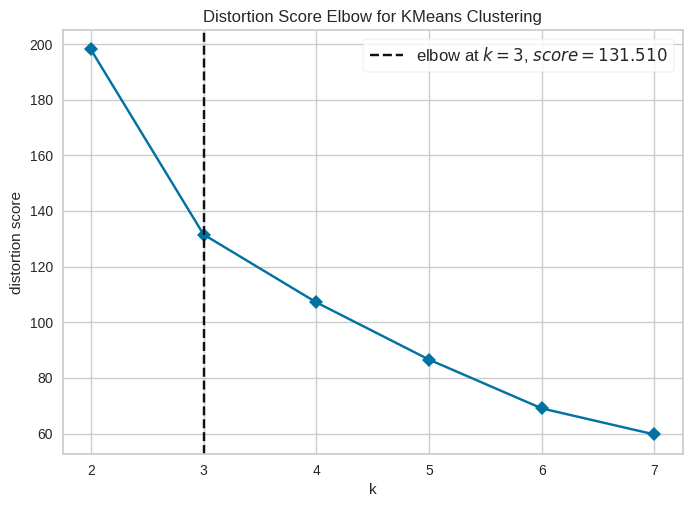

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [195]:
kmeans = KMeans()
viz = KElbowVisualizer(kmeans, k = (2,8), timings = False)
viz.fit(X)
viz.show()

3 clusters seems to be the best

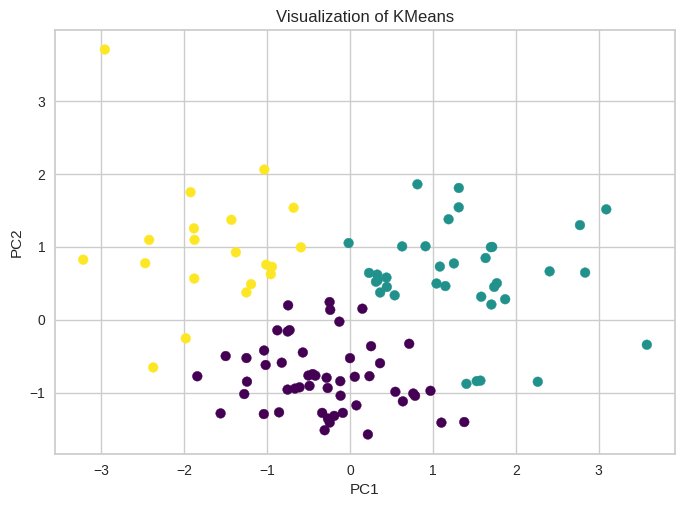

In [221]:
pca = PCA(n_components=2)
pcs = pca.fit(X)
to_viz = pca.components_[[0,1]]
dim_viz = np.dot(X, to_viz.T)
df_pca = pd.DataFrame(dim_viz, columns=['PC1', 'PC2'])

kmeans_tuned = KMeans(n_clusters=3)
y_fit_kmeans = kmeans_tuned.fit_predict(X)

plt.scatter(df_pca['PC1'], df_pca['PC2'], c=y_fit_kmeans, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of KMeans')
plt.show()

In [222]:
from sklearn.metrics import silhouette_score

silhouette_score(X = X, labels = y_fit_kmeans)

0.40136968463345496

In [236]:
gender_df['KMeans Cluster'] = y_fit_kmeans

#### KMedians

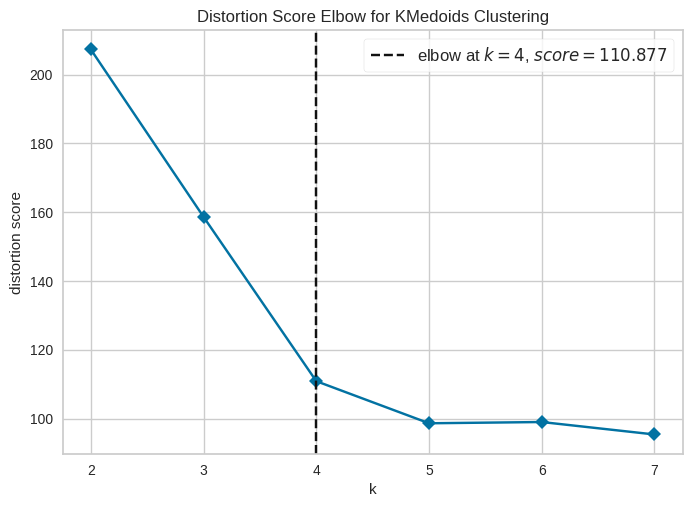

<AxesSubplot:title={'center':'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [223]:
from sklearn_extra.cluster import KMedoids
# Using the same standardize data used before


kmedoids = KMedoids()
viz = KElbowVisualizer(kmedoids, k = (2,8), timings = False)
viz.fit(X)
viz.show()

Best number of clusters for K Medians seems to be 4

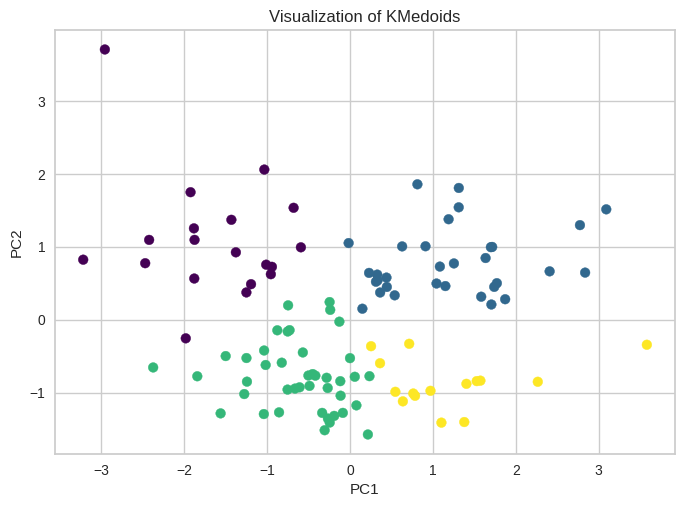

In [224]:
kmedoids_tuned = KMeans(n_clusters=4)
y_fit_kmedians = kmedoids_tuned.fit_predict(X)

plt.scatter(df_pca['PC1'], df_pca['PC2'], c=y_fit_kmedians, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of KMedoids')
plt.show()

In [225]:
silhouette_score(X = X, labels = y_fit_kmedians)

0.37824508781289085

In [237]:
gender_df['KMedians Cluster'] = y_fit_kmedians

#### DBSCAN

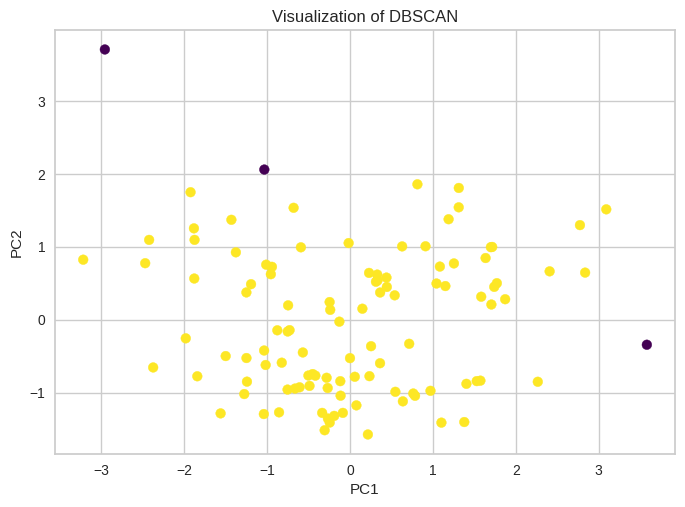

0.5037017404194467


In [252]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=1, min_samples=4).fit(X)

plt.scatter(df_pca['PC1'], df_pca['PC2'], c=clusters.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of DBSCAN')
plt.show()
print(silhouette_score(X = X, labels = clusters.labels_))

In [238]:
gender_df['DBSCAN Cluster'] = clusters.labels_

#### Results and Findings

As seen above, the clustering method with the best silhouette score is DBSCAN, which means the clustering from that method is the highest quality.

In [239]:
gender_df

,Loc,Gender,Healthy Weight,No Physical Activity,Obesity,KMeans Cluster,KMedians Cluster,DBSCAN Cluster
0,AK,Female,38.6,24.7,29.6,1,1,0
1,AK,Male,26.0,18.2,33.8,0,2,0
2,AL,Female,28.0,32.1,40.3,2,0,0
3,AL,Male,22.8,25.2,37.7,0,2,0
4,AR,Female,34.1,34.0,39.1,2,0,0
...,...,...,...,...,...,...,...,...
103,WI,Male,24.6,19.0,32.5,0,2,0
104,WV,Female,30.8,33.2,37.6,2,0,0
105,WV,Male,22.9,26.0,40.5,2,2,0
106,WY,Female,38.7,24.6,31.4,1,1,0


The following (Locations, Gender) pairs are similar in terms of prevelance healthy weight, no physical activity, and obesity according to KMeans

In [245]:
print(gender_df.loc[gender_df["KMeans Cluster"] == 0, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["KMeans Cluster"] == 1, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["KMeans Cluster"] == 2, ['Loc', 'Gender']].head(5))

  Loc Gender
1  AK   Male
3  AL   Male
5  AR   Male
7  AZ   Male
9  CA   Male
   Loc  Gender
0   AK  Female
6   AZ  Female
8   CA  Female
10  CO  Female
11  CO    Male
   Loc  Gender
2   AL  Female
4   AR  Female
16  DE  Female
20  GA  Female
22  GU  Female


The following (Locations, Gender) pairs are similar in terms of prevelance healthy weight, no physical activity, and obesity according to KMedians

In [246]:
print(gender_df.loc[gender_df["KMedians Cluster"] == 0, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["KMedians Cluster"] == 1, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["KMedians Cluster"] == 2, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["KMedians Cluster"] == 3, ['Loc', 'Gender']].head(5))

   Loc  Gender
2   AL  Female
4   AR  Female
16  DE  Female
20  GA  Female
22  GU  Female
   Loc  Gender
0   AK  Female
6   AZ  Female
8   CA  Female
10  CO  Female
12  CT  Female
   Loc Gender
1   AK   Male
3   AL   Male
5   AR   Male
7   AZ   Male
17  DE   Male
   Loc Gender
9   CA   Male
11  CO   Male
13  CT   Male
15  DC   Male
19  FL   Male


The following (Locations, Gender) pairs are similar in terms of prevelance healthy weight, no physical activity, and obesity according to DBSCAN

In [253]:
print(gender_df.loc[gender_df["DBSCAN Cluster"] == 0, ['Loc', 'Gender']].head(5))
print(gender_df.loc[gender_df["DBSCAN Cluster"] == 1, ['Loc', 'Gender']].head(5))

  Loc  Gender
0  AK  Female
1  AK    Male
2  AL  Female
3  AL    Male
4  AR  Female
Empty DataFrame
Columns: [Loc, Gender]
Index: []


As shown above, DBSCAN seems to only give 1 cluster, meaning that all (Location, Gender) combinations are similar in terms of prevelance healthy weight, no physical activity, and obesity.

### Bias and Fairness

In [254]:
gender_df

,Loc,Gender,Healthy Weight,No Physical Activity,Obesity,KMeans Cluster,KMedians Cluster,DBSCAN Cluster
0,AK,Female,38.6,24.7,29.6,1,1,0
1,AK,Male,26.0,18.2,33.8,0,2,0
2,AL,Female,28.0,32.1,40.3,2,0,0
3,AL,Male,22.8,25.2,37.7,0,2,0
4,AR,Female,34.1,34.0,39.1,2,0,0
...,...,...,...,...,...,...,...,...
103,WI,Male,24.6,19.0,32.5,0,2,0
104,WV,Female,30.8,33.2,37.6,2,0,0
105,WV,Male,22.9,26.0,40.5,2,2,0
106,WY,Female,38.7,24.6,31.4,1,1,0


In [260]:
healthy_weight_df = gender_df.loc[:, ["Loc", "Gender", "Healthy Weight"]]
df_hw = healthy_weight_df.pivot(index=['Loc'],columns=['Gender'], values=['Healthy Weight'])
no_phy_df = gender_df.loc[:, ["Loc", "Gender", "No Physical Activity"]]
df_np = no_phy_df.pivot(index=['Loc'],columns=['Gender'], values=['No Physical Activity'])
obesity_df = gender_df.loc[:, ["Loc", "Gender", "Obesity"]]
df_ob = obesity_df.pivot(index=['Loc'],columns=['Gender'], values=['Obesity'])

Text(0.5, 1.0, 'Healthy Weight Prevelance Between Mena and Women')

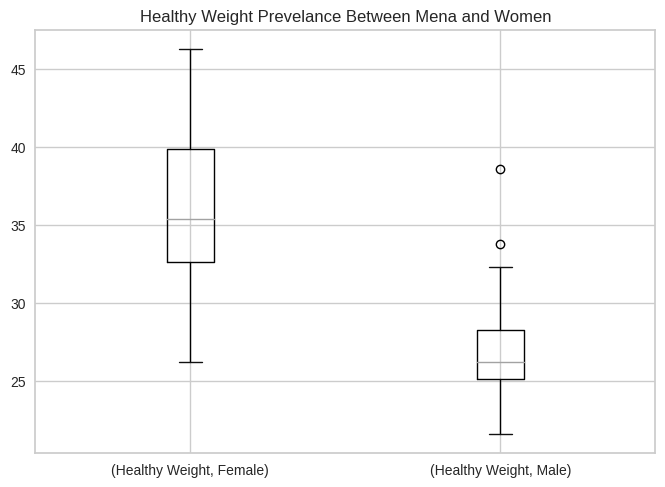

In [261]:
df_hw.reset_index().boxplot()
plt.title('Healthy Weight Prevelance Between Men and Women By State')

Text(0.5, 1.0, 'No Physical Activity Prevelance Between Men and Women')

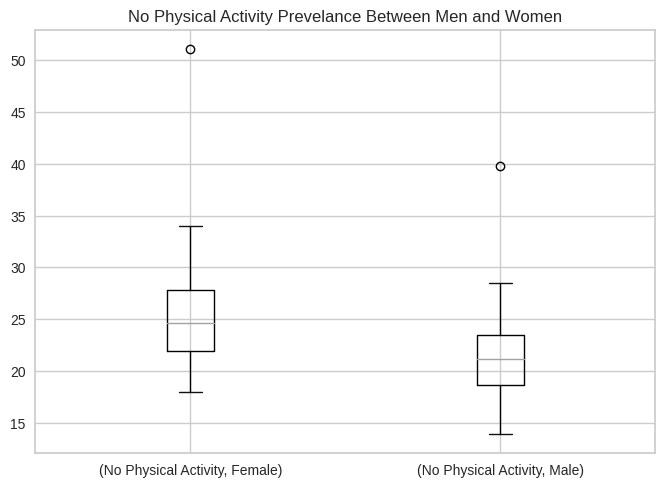

In [262]:
df_np.reset_index().boxplot()
plt.title('No Physical Activity Prevelance Between Men and Women By State')

Text(0.5, 1.0, 'Obesity Prevelance Between Men and Women')

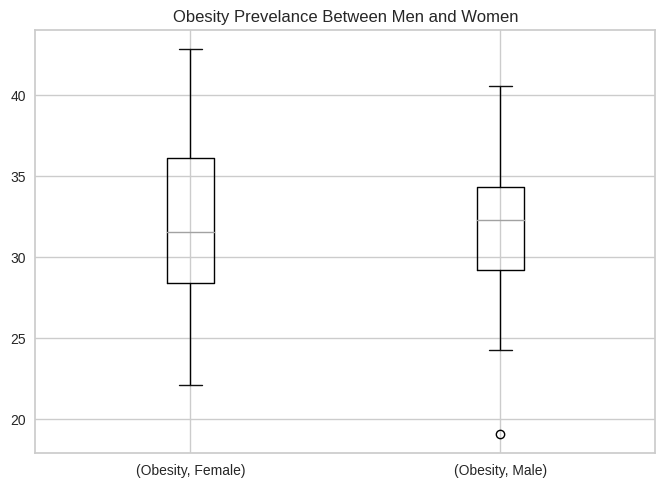

In [263]:
df_ob.reset_index().boxplot()
plt.title('Obesity Prevelance Between Men and Women By State')

There could be possible bias in determining overall health in terms of gender. Looking at the first boxplot, the healthy weight prevelance for men seems to be siginificanly lower than women. This could cause issues when we are trying to determine root cause of obesity in people. For example, we cannot simply say that being male increases chances of not having a healthy weight. There are other factors (probably way more important ones than gender) that one must look at

In [378]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


X = healthy_weight_df
y = X['Healthy Weight']
X = X.drop(labels = 'Healthy Weight', axis = 1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gender = X_test.loc[:, ["Gender_Female", "Gender_Male"]].idxmax(axis = 1)
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)


In [379]:
tree = DecisionTreeRegressor()
tree = tree.fit(X_train, y_train)
pred = tree.predict(X_test)

In [380]:
pred

array([26.2, 35.4, 35.4, 26.2, 35.4, 26.2, 35.4, 26.2, 26.2, 26.2, 26.2,
       26.2, 35.4, 35.4, 35.4, 26.2, 35.4, 35.4, 35.4, 35.4, 35.4, 35.4,
       35.4, 35.4, 35.4, 26.2, 26.2, 35.4, 26.2, 35.4, 35.4, 26.2, 26.2,
       26.2, 26.2, 26.2])

In [381]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import mean_squared_error
gm = MetricFrame(metrics = mean_squared_error, y_true = y_test, y_pred = pred, sensitive_features=gender)

In [382]:
print(gm.by_group)

sensitive_feature_0
Gender_Female    14.821579
Gender_Male      16.590000
Name: mean_squared_error, dtype: float64


As seen above, model performance differs for different gender groups. Bias and Fairness issues could be mitigated by considering more factors that affect healthy weight prevelance